# Plotting Breeds by Similarity of Names

Using some LSA stuff to plot dog breeds by the names used for each breed - very similar to some of the "Movie Math" stuff I did here: https://github.com/SimonCarryer/HannibalVector

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

% matplotlib inline

In [28]:
from load_data import load_dog_data, get_main_breeds_df

In [29]:
df = load_dog_data()
main_breeds = get_main_breeds_df(df, breed_threshold=300, name_threshold=100)

In [30]:
main_breeds[['DogName', 'breed_no_mix']].head(10)

,DogName,breed_no_mix
1,SABLE,AM PIT BULL TERRIER
8,TAFFY,POMERANIAN
9,BELLE,BEAGLE
10,BELLE,BEAGLE
11,SASHA,AM SPITZ
13,HERCULES,GER SHEPHERD
15,CHLOE,BOXER
19,TROY,BOXER
20,NICO,SILKY TERRIER
21,CODY,SHIH TZU


In [31]:
def make_matrix(df):
    names = list(df.DogName.unique())
    breeds = list(df.breed_no_mix.unique())
    data = np.ones(len(df))
    col = df.DogName.astype('category', categories=names).cat.codes
    row = df.breed_no_mix.astype('category', categories=breeds).cat.codes
    N = len(names)
    return csr_matrix((data, (row, col)), shape=(len(breeds), len(names))), breeds

In [32]:
matrix, breeds = make_matrix(main_breeds[['DogName', 'breed_no_mix']])

In [33]:
megatron = TfidfTransformer()

weighted = megatron.fit_transform(matrix)


In [34]:
dot_product = weighted.dot(weighted.T)

In [35]:
def get_closest_n(matrix, breeds, target_name, number=10):
    target = breeds.index(target_name)
    distances = pd.Series([i[0] for i in pairwise_distances(matrix, matrix[target], metric='euclidean')]).argsort().values
    similars = [breeds[n] for n in distances[:number]]
    return similars

In [36]:
get_closest_n(dot_product, breeds, 'BOXER')

['BOXER',
 'AM PITT BULL',
 'GER SHEPHERD',
 'PUG',
 'BOSTON TERRIER',
 'TAG',
 'LABRADOR RETRIEVER',
 'TERRIER',
 'YORKSHIRE TERRIER',
 'BORD COLLIE']

In [37]:
shrinky = TruncatedSVD(2)
shrunk_matrix = shrinky.fit_transform(dot_product)

In [38]:
coords = pd.DataFrame(shrunk_matrix)
coords.index = breeds
coords.columns = ['x', 'y']

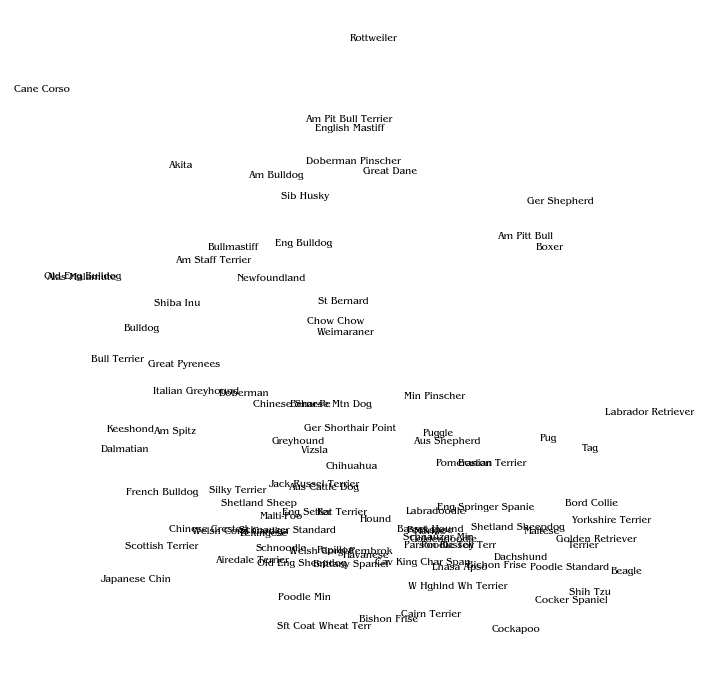

In [79]:
fig = coords.plot(kind='scatter', 
            x='x', 
            y='y', 
            figsize=(12,12),
           c='white')
for name, coordinates in coords.iterrows():
    plt.annotate(name.title(), 
                 xy = (coordinates.x, coordinates.y),
                 horizontalalignment='center',
                 fontname='Benguiat'
    )
plt.xlabel('')
plt.ylabel('')
fig.set_yticks([])
fig.set_xticks([])
fig.set_frame_on(False)

plt.savefig('breed_chart.png', bbox_inches='tight')
plt.show()

In [40]:
def apply_fisher(row):
    ratio, p_value = fisher_exact([[row.name_in_breed, row.name_not_breed],
                            [row.breed_not_name, row.not_name_not_breed]])
    return p_value

def get_name_associations(df, column_name):
    names_by_breed = main_breeds.groupby([column_name, 'DogName'])['LicenseType'].count()
    names = main_breeds.groupby('DogName')['DogName'].count()
    breeds = main_breeds.groupby(column_name)['breed_no_mix'].count()
    tabulated = pd.DataFrame(names_by_breed).join(names).join(breeds)
    tabulated.columns = ['name_in_breed', 'name_total', 'breed_total']
    tabulated['total_dogs'] = len(main_breeds)
    tabulated['name_not_breed'] = tabulated.name_total - tabulated.name_in_breed
    tabulated['breed_not_name'] = tabulated.breed_total - tabulated.name_in_breed
    tabulated['not_name_not_breed'] = tabulated.total_dogs - tabulated.name_not_breed
    tabulated['breed_odds'] = tabulated.name_in_breed/tabulated.breed_not_name
    tabulated['not_breed_odds'] = tabulated.name_not_breed/tabulated.not_name_not_breed
    tabulated['odds_ratio'] = tabulated.breed_odds/tabulated.not_breed_odds
    tabulated['p_value'] = tabulated.apply(apply_fisher,
                            axis=1
                            )
    return tabulated

In [49]:
high_y = coords[coords.y > coords.y.quantile(0.75)].index.values
low_y = coords[coords.y < coords.y.quantile(0.25)].index.values
high_x = coords[coords.x > coords.x.quantile(0.75)].index.values
low_x = coords[coords.x < coords.x.quantile(0.25)].index.values

breed_set_names = {}

for breed_set, set_name in [(high_x, 'high x'), (low_x, 'low x'), (high_y, 'high y'), (low_y, 'low y')]:
    main_breeds['in_group'] = main_breeds.breed_no_mix.isin(breed_set)
    tabulated = get_name_associations(main_breeds, 'in_group')
    names = tabulated[tabulated.p_value < 0.05].loc[True].sort_values(by='odds_ratio', ascending=False).index.values[:10]
    breed_set_names[set_name] = names
    print set_name, names





/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


high x ['TIPPY' 'JESSE' 'SALLY' 'CLOVER' 'PUPPY' 'KELLY' 'BLACKIE' 'MIKEY'
 'REILLY' 'MIDNIGHT']
low x ['DOMINO' 'SNOWBALL' 'XENA' 'PATCH' 'MONTY' 'BUD' 'SPOT' 'OLIVIA' 'FLUFFY'
 'FIONA']
high y ['CAPONE' 'KANE' 'ISIS' 'ATHENA' 'XENA' 'NIKITA' 'DIESEL' 'TITAN' 'KING'
 'STORM']
low y ['BUTTONS' 'SCRUFFY' 'GIDGET' 'SNOOPY' 'SNUGGLES' 'BENJI' 'FRECKLES'
 'MUFFIN' 'CUDDLES' 'SPANKY']
